In [15]:
# Load Seurat object and create pseudobulk for MOFA analysis based on azimuth annotations

#############################################
# Prerequisites - Load Libraries

In [16]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"


###############################################
# Preqrequisites Configurations & Parameters

In [17]:
data_path =  '../data/current'

In [18]:
result_path =  '../results/current'

In [19]:
data_path

[1] "../data/current"

In [20]:
libraries = c('L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10','L11', 'L12', 'L13', 'L14')

# Load Data 

## Load Seurat object

In [21]:
### Raw data counts
# contains raw count matrix filtered on only Singlets for all genes (~19.000)

In [22]:
###### Load the generated seurat objects

source_text = paste( data_path, '/analysis/B/B6_DE_Integrated_Singlet_processed_rna.h5seurat', sep = '')
print(source_text)
print(file.info(source_text)$mtime)
rna_seurat_data = LoadH5Seurat(source_text, assays = "RNA", quietly = TRUE )


[1] "../data/current/analysis/B/B6_DE_Integrated_Singlet_processed_rna.h5seurat"
[1] "2023-01-21 12:14:40 CET"


Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding command information

Adding cell-level metadata



In [23]:
rna_seurat_data_raw = rna_seurat_data

In [24]:
### Decide what to use as input

In [25]:
rna_seurat_data = rna_seurat_data

In [26]:
### Further data checks

In [27]:
head(colSums(x = rna_seurat_data, slot = "counts") )  # raw count values from original matrix

AAACCCACATACAGGG-1-L1 AAACCCACATGACTTG-1-L1 AAACCCAGTCATCAGT-1-L1 
                 3947                  5870                  3888 
AAACCCAGTGGTAATA-1-L1 AAACCCATCATCACAG-1-L1 AAACCCATCGATGGAG-1-L1 
                 5094                 17310                  4839

In [28]:
# str(rna_seurat_data)

In [29]:
DefaultAssay(rna_seurat_data)

[1] "RNA"

In [30]:
rna_seurat_data

An object of class Seurat 
19221 features across 148275 samples within 1 assay 
Active assay: RNA (19221 features, 0 variable features)
 3 layers present: counts, data, scale.data

## Azimuth Annotation File

In [31]:
### Load the saved azimuth annotations to add to seurat object

In [32]:
path = paste0(data_path, '/analysis/G/G2_Cell_Annotations_Azimuth.csv')
azimuth_annotation = read.csv(path)
print(file.info(source_text)$mtime)

[1] "2023-01-21 12:14:40 CET"


In [33]:
### concatenate cell and library identifier

In [34]:
azimuth_annotation$cell_library = paste0(azimuth_annotation$cell, '-', azimuth_annotation$library)

In [35]:
### Combine B-cell annotations (as they should be merged in one annotation):
azimuth_annotation$predicted.celltype.l2 = str_replace(azimuth_annotation$predicted.celltype.l2 ,
                                                       'B naive|B memory|B intermediate', 'B cell')

In [36]:
### Define cell-type to use in the end

In [37]:
total_azimuth_filter = azimuth_annotation %>% group_by(predicted.celltype.l2) %>% dplyr::count()

In [38]:
total_azimuth_filter = total_azimuth_filter[total_azimuth_filter$n > 1000,c('predicted.celltype.l2')]

In [39]:
#total_azimuth_filter

In [41]:
### Load the mapping of azimuth annotations from Roy 
# (in the Groningen data cell-types are named differently than the azimuth output
# this maps the two different names onto each other)

In [43]:
azimuth_mapping = read.csv(paste0(result_path, '/Reproduction/azimuth_roy_mapping.csv'))

In [44]:
azimuth_mapping = azimuth_mapping[azimuth_mapping$annot != '',]

In [45]:
head(azimuth_mapping,2)

,annot_roy,annot
,<chr>,<chr>
2,B_intermediate,B intermediate
3,B_memory,B memory


# Data Processing

## Subset data

In [46]:
dim(rna_seurat_data)

[1]  19221 148275

In [47]:
rna_seurat_data_subset = rna_seurat_data

In [48]:
dim(rna_seurat_data_subset)

[1]  19221 148275

## Define columns for aggregation to pseudobulk + data type conversions

In [49]:
# Define column containing sample- identifier
sample_column = 'display_name' 

In [50]:
# Define column containing cell-type annotations
cluster_column =  'predicted.celltype.l2' 

In [51]:
# Adjust meta-data based on definitiona

In [52]:
obs = rna_seurat_data_subset@meta.data

In [53]:
obs$cell = rownames(obs)

In [55]:
head(obs,2)

,nCount_HTO,B2_Scanorama_Singlet_cluster,B2_Scanorama_Singlet_rb_mt_cluster,cell_type_Scanorama,cluster_cell_type_Scanorama,classification_measurement,delta_ef_value_group_measurement,m_y,measurement_y,delta_ef_value_group,⋯,library,id,read,pattern,sequence,feature_type,in_sample,display_name,group_x,cell
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>
AAACCCACATACAGGG-1-L1,1574,8,8,B-cell,8_B-cell,acs_w_o_infection_TP1,x_greater_1_TP1,"M9 (14,3)",TP1,x_greater_1,⋯,L1,HTO_B0259,R2,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,1,9.1,TP1,AAACCCACATACAGGG-1-L1
AAACCCACATGACTTG-1-L1,379,9,9,Monocytes - CD16_FCGR3A,9_Monocytes - CD16_FCGR3A,acs_w_o_infection_TP1,x_greater_1_TP1,"M9 (14,3)",TP1,x_greater_1,⋯,L1,HTO_B0259,R2,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,1,9.1,TP1,AAACCCACATGACTTG-1-L1


In [57]:
colnames(obs)

[1] "nCount_HTO"                         "B2_Scanorama_Singlet_cluster"      
 [3] "B2_Scanorama_Singlet_rb_mt_cluster" "cell_type_Scanorama"               
 [5] "cluster_cell_type_Scanorama"        "classification_measurement"        
 [7] "delta_ef_value_group_measurement"   "m_y"                               
 [9] "measurement_y"                      "delta_ef_value_group"              
[11] "delta_ef_value"                     "sample_y"                          
[13] "age"                                "sex"                               
[15] "m_x"                                "classification"                    
[17] "group_y"                            "measurement_x"                     
[19] "sample_x"                           "library"                           
[21] "id"                                 "read"                              
[23] "pattern"                            "sequence"                          
[25] "feature_type"                       "in_sample"                         
[27] "display_name"                       "group_x"                           
[29] "cell"

In [58]:
obs$library = as.character(obs$library)

In [59]:
obs$group_id = as.character(obs[['in_sample']]) ## DUMMY variable as group-id is needed for aggregation to pseudobulk (with the used function)

In [60]:
obs$sample_id   = paste0(as.character(obs[[sample_column]] ), '-', obs$library)

In [61]:
## add azimuth annotations to the obs meta-data

In [62]:
head(azimuth_annotation,2)

,X,nCount_RNA,nFeature_RNA,predicted.celltype.l2,predicted.celltype.l2.score,library,cell,cell_library
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,AAACCCACATACAGGG-1,3947,1232,B cell,0.9668187,L1,AAACCCACATACAGGG-1,AAACCCACATACAGGG-1-L1
2,AAACCCACATGACTTG-1,5871,1890,CD16 Mono,1.0000000,L1,AAACCCACATGACTTG-1,AAACCCACATGACTTG-1-L1


In [63]:
obs = merge(obs, azimuth_annotation[,c( 'predicted.celltype.l2','cell_library' )], by.x = 'cell', by.y = 'cell_library' )

In [64]:
nrow(obs)

[1] 148275

In [65]:
### Define the different columns

In [66]:
obs$cluster_id = as.character(obs[[cluster_column]])

In [67]:
rownames(obs) = obs$cell

In [68]:
### Add to the seurat dataset

In [69]:
rna_seurat_data_subset = AddMetaData(object = rna_seurat_data_subset, metadata = obs[,'library', drop = FALSE], col.name = 'library_char')

In [70]:
rna_seurat_data_subset = AddMetaData(object = rna_seurat_data_subset, metadata = obs[,'group_id', drop = FALSE], col.name = 'group_id')

In [71]:
rna_seurat_data_subset = AddMetaData(object = rna_seurat_data_subset, metadata = obs[,'cluster_id', drop = FALSE], col.name = 'cluster_id')

In [72]:
rna_seurat_data_subset = AddMetaData(object = rna_seurat_data_subset, metadata = obs[,'sample_id', drop = FALSE], col.name = 'sample_id')

In [73]:
head(rna_seurat_data_subset@meta.data)

,nCount_HTO,B2_Scanorama_Singlet_cluster,B2_Scanorama_Singlet_rb_mt_cluster,cell_type_Scanorama,cluster_cell_type_Scanorama,classification_measurement,delta_ef_value_group_measurement,m_y,measurement_y,delta_ef_value_group,⋯,pattern,sequence,feature_type,in_sample,display_name,group_x,library_char,group_id,cluster_id,sample_id
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
AAACCCACATACAGGG-1-L1,1574,8,8,B-cell,8_B-cell,acs_w_o_infection_TP1,x_greater_1_TP1,"M9 (14,3)",TP1,x_greater_1,⋯,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,1,9.1,TP1,L1,1,B cell,9.1-L1
AAACCCACATGACTTG-1-L1,379,9,9,Monocytes - CD16_FCGR3A,9_Monocytes - CD16_FCGR3A,acs_w_o_infection_TP1,x_greater_1_TP1,"M9 (14,3)",TP1,x_greater_1,⋯,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,1,9.1,TP1,L1,1,CD16 Mono,9.1-L1
AAACCCAGTCATCAGT-1-L1,421,5,5,T-cell-CD4,5_T-cell-CD4,acs_w_o_infection_TP1,x_smaller_1_TP1,"M7 (0,75)",TP1,x_smaller_1,⋯,5PNNNNNNNNNN(BC),TGTCTTTCCTGCCAG,Antibody Capture,1,7.1,TP1,L1,1,CD4 TCM,7.1-L1
AAACCCAGTGGTAATA-1-L1,478,0,0,T-cell-CD4,0_T-cell-CD4,acs_w_o_infection_TP1,x_greater_1_TP1,"M9 (14,3)",TP1,x_greater_1,⋯,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,1,9.1,TP1,L1,1,CD4 TCM,9.1-L1
AAACCCATCATCACAG-1-L1,851,16,16,Plasma Blast,16_Plasma Blast,acs_w_o_infection_TP1,x_greater_1_TP1,"M9 (14,3)",TP1,x_greater_1,⋯,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,1,9.1,TP1,L1,1,Plasmablast,9.1-L1
AAACCCATCGATGGAG-1-L1,473,0,0,T-cell-CD4,0_T-cell-CD4,acs_subacute_TP1,missing,missing,missing,missing,⋯,5PNNNNNNNNNN(BC),CTCCTCTGCAATTAC,Antibody Capture,1,8.1,TP1,L1,1,CD4 TCM,8.1-L1


In [74]:
### Save merged Seurat data with azimuth annotation for reproduction file to share

In [75]:
#save( rna_seurat_data_subset , file = paste0(result_path, '/G-Analysis/G4_Seurat_Input_Replication.RDS'))

In [76]:
rna_seurat_data_save = rna_seurat_data_subset

In [77]:
### Remove some unnecessary columsn

In [78]:
rna_seurat_data_save$B2_Scanorama_Singlet_cluster = NULL
rna_seurat_data_save$B2_Scanorama_Singlet_rb_mt_cluster = NULL
rna_seurat_data_save$cell_type_Scanorama = NULL
rna_seurat_data_save$cluster_cell_type_Scanorama = NULL

In [79]:
rna_seurat_data_save$delta_ef_value_group_measurement = NULL
rna_seurat_data_save$m_y = NULL
rna_seurat_data_save$measurement_y = NULL
rna_seurat_data_save$delta_ef_value_group = NULL

In [80]:
rna_seurat_data_save$classification_measurement = NULL
rna_seurat_data_save$delta_ef_value = NULL
rna_seurat_data_save$sample_y = NULL
rna_seurat_data_save$age = NULL

In [81]:
rna_seurat_data_save$sex = NULL
rna_seurat_data_save$m_x = NULL
rna_seurat_data_save$classification = NULL
rna_seurat_data_save$group_y = NULL

In [82]:
rna_seurat_data_save$measurement_x = NULL
rna_seurat_data_save$sample_x = NULL
rna_seurat_data_save$library = NULL
rna_seurat_data_save$id = NULL

In [83]:
rna_seurat_data_save$read = NULL
rna_seurat_data_save$pattern = NULL
rna_seurat_data_save$sequence = NULL
rna_seurat_data_save$feature_type = NULL

In [84]:
rna_seurat_data_save$in_sample = NULL
rna_seurat_data_save$display_name = NULL
rna_seurat_data_save$group_x = NULL
rna_seurat_data_save$library_char = NULL

In [85]:
colnames(rna_seurat_data_save[[]])

[1] "nCount_HTO" "group_id"   "cluster_id" "sample_id"

In [221]:
#SaveH5Seurat(rna_seurat_data_save, file = paste0(result_path, '/Reproduction/G4_Seurat_Input_Replication.h5seurat'), overwrite = TRUE)

## Convert to SCE 

In [86]:
### convert format to sce

In [87]:
rna_sce = as.SingleCellExperiment(rna_seurat_data_subset)

In [88]:
rna_sce  # rows = genes; columns = cells

class: SingleCellExperiment 
dim: 19221 148275 
metadata(0):
assays(2): counts logcounts
rownames(19221): AL627309.1 AL627309.4 ... AC004556.1 AC240274.1
rowData names(0):
colnames(148275): AAACCCACATACAGGG-1-L1 AAACCCACATGACTTG-1-L1 ...
  TTTGTTGGTGGACCAA-1-L14 TTTGTTGTCGAAGAAT-1-L14
colData names(33): nCount_HTO B2_Scanorama_Singlet_cluster ...
  sample_id ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

## Calculate amount of cells per sample and cluster

In [90]:
## Amount of cells per azimuth cell-type annotation

In [91]:
colSums(table(rna_sce$cluster_id,rna_sce$cluster_id ))

ASDC            B cell         CD14 Mono         CD16 Mono 
                8              9829             32727              4680 
          CD4 CTL         CD4 Naive CD4 Proliferating           CD4 TCM 
             2346              6495               108             45102 
          CD4 TEM         CD8 Naive CD8 Proliferating           CD8 TCM 
             6296              2612                13               525 
          CD8 TEM              cDC1              cDC2               dnT 
            10611                83              1314               130 
          Doublet             Eryth               gdT              HSPC 
               48                 6              1901               332 
              ILC              MAIT                NK  NK Proliferating 
              931              1177             15699               168 
    NK_CD56bright               pDC       Plasmablast          Platelet 
              874               745               703               450 
             Treg 
             2362

In [92]:
cells_per_sample_cluster = t(table(rna_sce$cluster_id, rna_sce$sample_id))

In [93]:
head(as.data.frame(cells_per_sample_cluster),2)

,Var1,Var2,Freq
,<fct>,<fct>,<int>
1,1.1-L1,ASDC,0
2,10-L11,ASDC,0


In [ ]:
## Save the amount of cells per sample and cluster

In [94]:
write.csv(cells_per_sample_cluster, paste0(result_path, '/G-Analysis/G1_Cell_Sample_Cluster_Distribution.csv'))

In [96]:
## Visualize

In [97]:
cells_per_sample_cluster = data.frame(cells_per_sample_cluster)

In [98]:
colnames(cells_per_sample_cluster) = c('Sample', 'Cluster_Cell_Type', 'amount_cells')

In [99]:
cells_per_sample_cluster$amount_cells_cat[(cells_per_sample_cluster$amount_cells <= 3)  ] = '0-3'

In [100]:
cells_per_sample_cluster$amount_cells_cat[(cells_per_sample_cluster$amount_cells <= 10)  & (cells_per_sample_cluster$amount_cells >3 )] = '3-10'

In [101]:
cells_per_sample_cluster$amount_cells_cat[(cells_per_sample_cluster$amount_cells <= 20)  & (cells_per_sample_cluster$amount_cells >10 )] = '10-20'

In [102]:
cells_per_sample_cluster$amount_cells_cat[(cells_per_sample_cluster$amount_cells <= 50)  & (cells_per_sample_cluster$amount_cells >20 )] = '20-50'

In [103]:
cells_per_sample_cluster$amount_cells_cat[(cells_per_sample_cluster$amount_cells > 50)  ] = '> 50'

In [104]:
sample_class = unique(obs[,c('classification', 'sample_id')])

In [105]:
cells_per_sample_cluster = merge(cells_per_sample_cluster, sample_class, by.x = 'Sample', by.y = 'sample_id')

In [106]:
cells_per_sample_cluster$cell_type = str_replace(cells_per_sample_cluster$Cluster_Cell_Type, '\\d.*_', '')

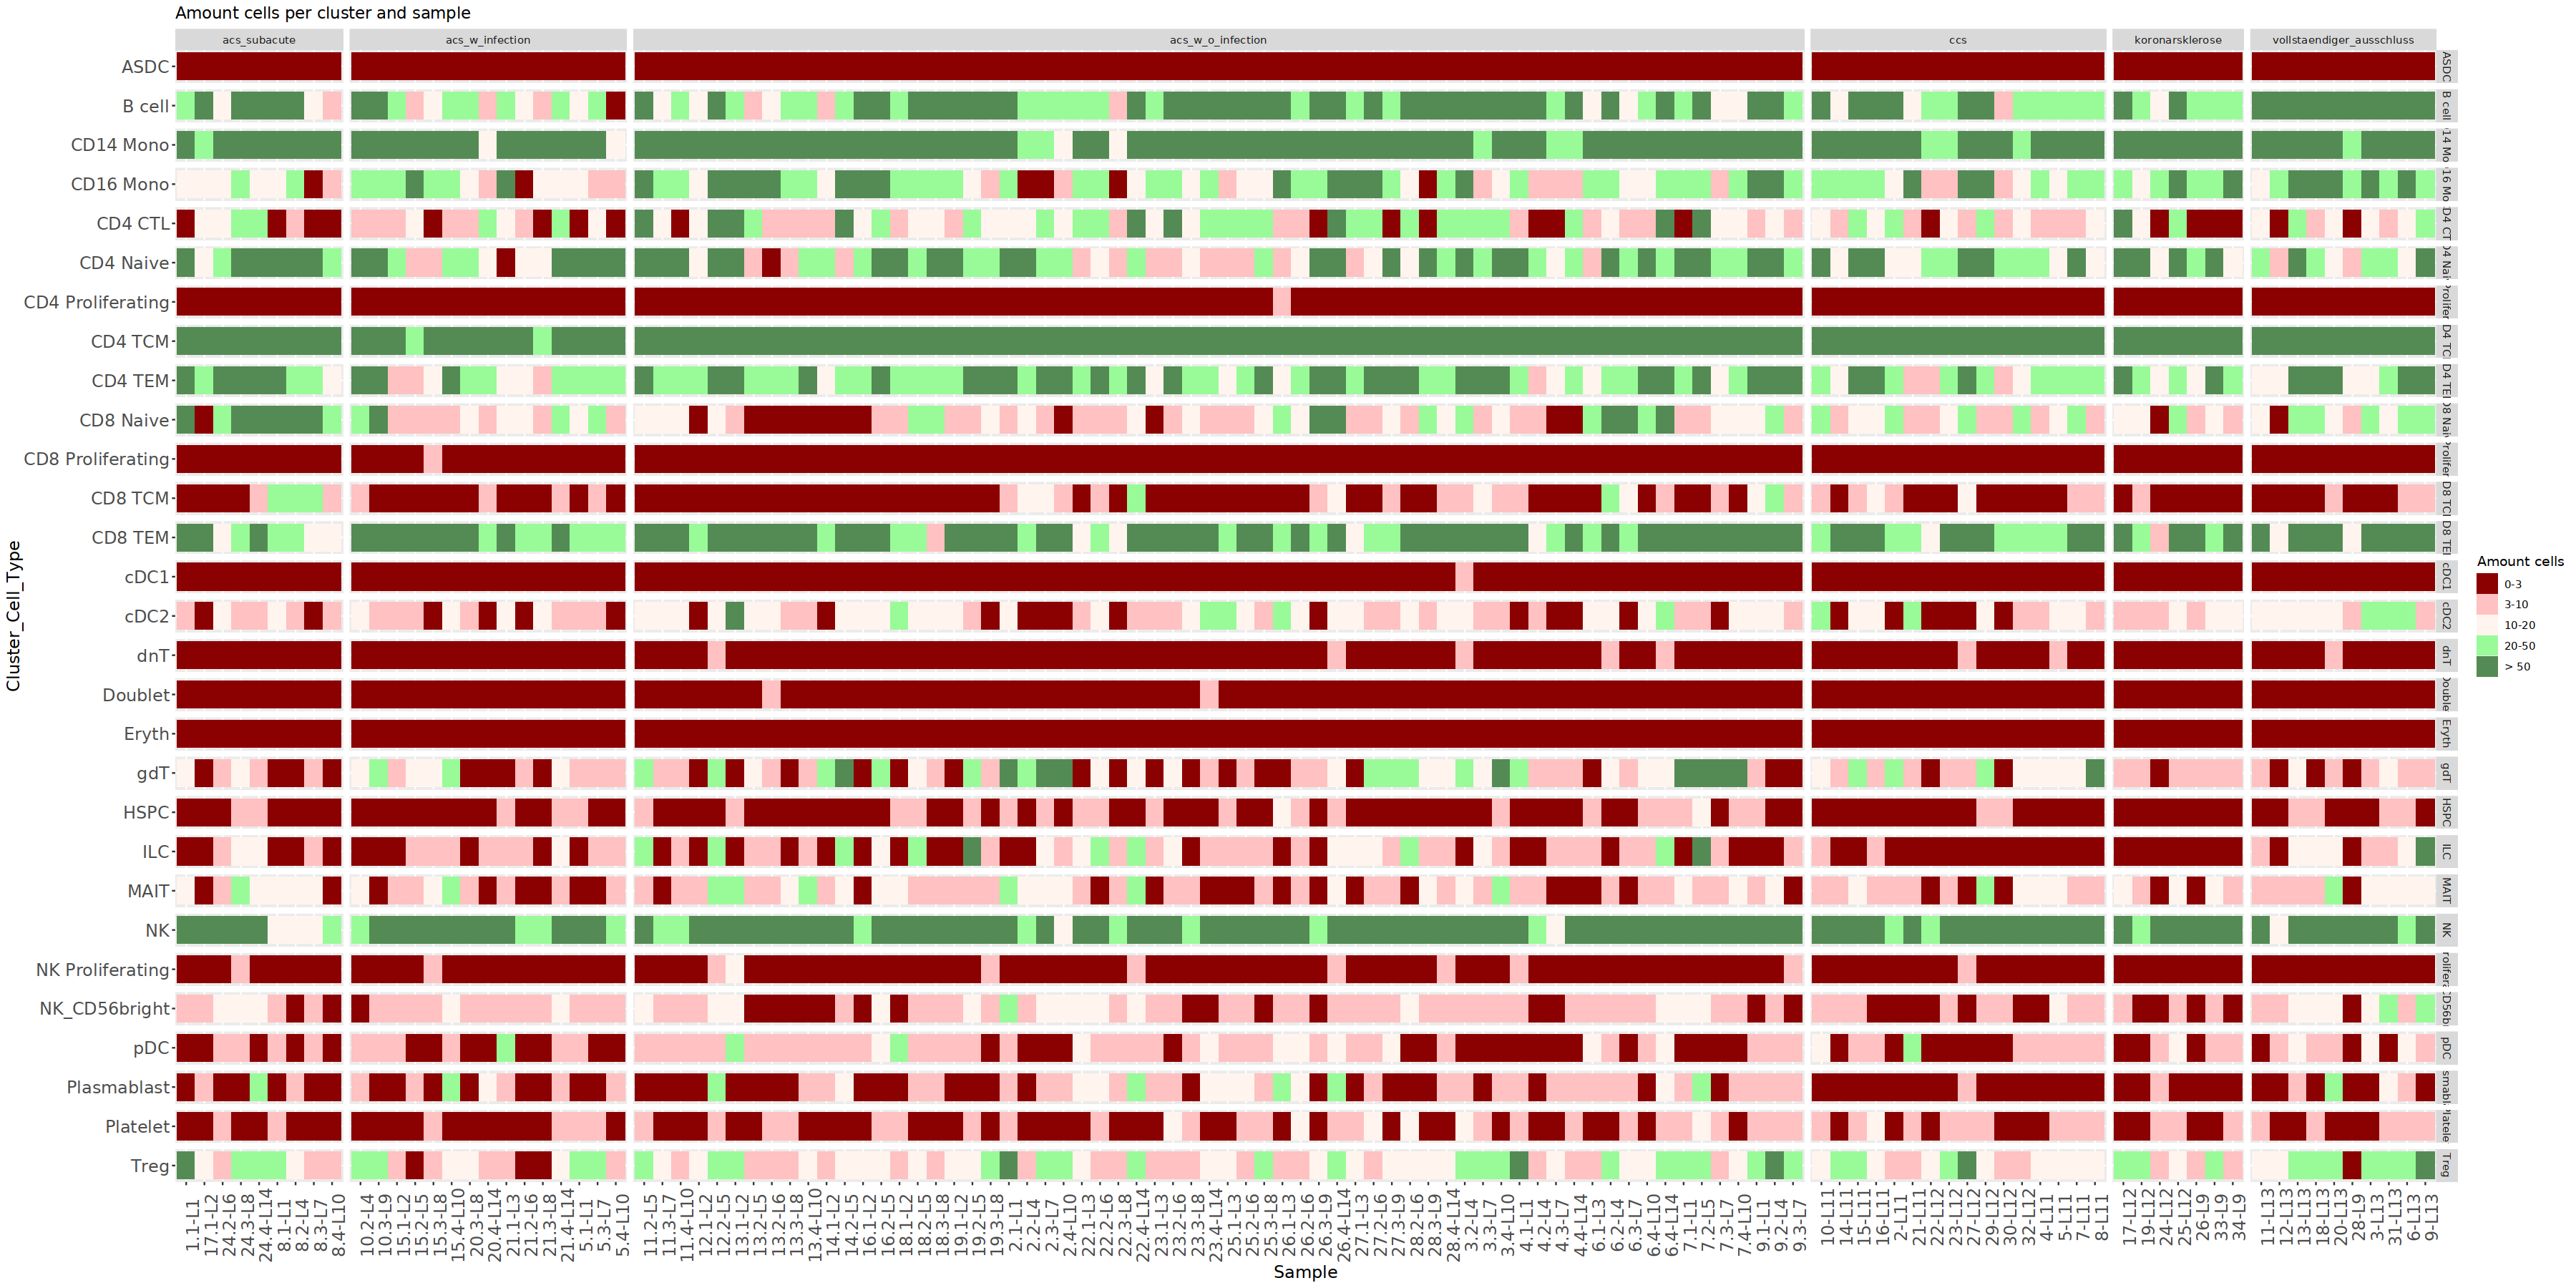

In [107]:
options(repr.plot.width=30, repr.plot.height=15)
g = ggplot(cells_per_sample_cluster, aes(Sample, Cluster_Cell_Type, fill= amount_cells_cat)) + facet_grid(cell_type ~ classification , scales = "free", space = "free") + geom_tile()   + ggtitle(label = "Amount cells per cluster and sample")+ theme(axis.text.x=element_text(size=14, angle = 90), axis.text.y=element_text(size=14, angle = 0),axis.title=element_text(size=14,face="bold")) + scale_fill_manual(name = "Amount cells", breaks=c( '0-3','3-10', 
                                 '10-20', '20-50', '> 50'), values =c("red4","rosybrown1",  "seashell", "palegreen", "palegreen4")) 
g

## Analyze gene expression percentages per cluster

In [112]:
## Determine the percentage of cells within a cluster expressing a gene

In [113]:
gene_list = list()

In [114]:
gene_cell_expr = list()

In [115]:
clusters = unique(rna_sce$cluster_id)

In [116]:
 for(i in clusters){
    
    # subset data on cluster
    rna_sce_subset = rna_sce[,rna_sce$cluster_id== i] # cluster
    
    amount_cells = dim(rna_sce_subset)[2]
    
    # Calculate percentage of cells expressing gene
    amount_cells_expressing_gene = rowSums(assay(rna_sce_subset) > 0 )
    perc_cells_expressing_gene = (amount_cells_expressing_gene/ amount_cells) * 100
    
    gene_cell_expr[[i]] = data.frame(perc_cells_expressing_gene = perc_cells_expressing_gene, total_amount_cells_expressing_gene = amount_cells_expressing_gene)
    
    }

In [117]:
### Format result in a data.frame

In [118]:
gene_cell_expr_data = data.frame()

In [119]:
 for(i in names(gene_cell_expr)){
    data = gene_cell_expr[[i]]
    data$gene = rownames(gene_cell_expr[[i]])
    data$cluster = i
    gene_cell_expr_data = rbind( gene_cell_expr_data, data)
    }

In [120]:
head(gene_cell_expr_data,2)

,perc_cells_expressing_gene,total_amount_cells_expressing_gene,gene,cluster
,<dbl>,<int>,<chr>,<chr>
AL627309.1,0.23400142,23,AL627309.1,B cell
AL627309.4,0.06104385,6,AL627309.4,B cell


In [121]:
## Save the data for filtering in next step

In [122]:
write.csv(gene_cell_expr_data, paste0(result_path, '/G-Analysis/G0_Filter_Genes_Input_Correlations_Perc_Values', '.csv'))

## Add cluster, group and sample columns for aggregation

In [123]:
#### Add cluster_id, sample_id and group_id columns
(rna_sce <- prepSCE(rna_sce, 
    kid = 'cluster_id', # cell-type annotations annotations
    gid = 'group_id',  # dummy variable
    sid = 'sample_id',   # sample IDs 
    drop = FALSE))  # drop all other colData columns

class: SingleCellExperiment 
dim: 19221 148275 
metadata(1): experiment_info
assays(2): counts logcounts
rownames(19221): AL627309.1 AL627309.4 ... AC004556.1 AC240274.1
rowData names(0):
colnames(148275): AAACCCACATACAGGG-1-L1 AAACCCACATGACTTG-1-L1 ...
  TTTGTTGGTGGACCAA-1-L14 TTTGTTGTCGAAGAAT-1-L14
colData names(33): cluster_id sample_id ... library_char ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [124]:
nk <- length(kids <- levels(rna_sce$cluster_id))
ns <- length(sids <- levels(rna_sce$sample_id))
names(kids) <- kids; names(sids) <- sids

In [125]:
nk # amount of cluster

[1] 29

In [126]:
ns # amount of samples

[1] 121

## Aggregate single cell to pseudo-bulk data

In [128]:
## Aggregate to pseudobulk

In [129]:
rna_sce

class: SingleCellExperiment 
dim: 19221 148275 
metadata(1): experiment_info
assays(2): counts logcounts
rownames(19221): AL627309.1 AL627309.4 ... AC004556.1 AC240274.1
rowData names(0):
colnames(148275): AAACCCACATACAGGG-1-L1 AAACCCACATGACTTG-1-L1 ...
  TTTGTTGGTGGACCAA-1-L14 TTTGTTGTCGAAGAAT-1-L14
colData names(33): cluster_id sample_id ... library_char ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [ ]:
pb <- aggregateData(rna_sce,
    assay = "counts", fun = "mean",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation

In [ ]:
pb

In [ ]:
### Save aggregated data

In [ ]:
save(  pb , file = paste0(result_path, '/G-Analysis/G0_aggregated_RNA_input_correlations_all.RDS'))